In [2]:
import pyForwardFolding as pyFF
import pandas as pd
import yaml
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jax
import pickle
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)


In [2]:
#Datasets = {
#"Northern Tracks":  pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_tracks_baseline_galactic/dataset_tracks_galactic.parquet"),
#"Cascades": pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_cscd_cascade_baseline/dataset_cscd_cascade_baseline_all_keys_galactic.parquet"),
#"Cascades Muon": pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_cscd_muon_baseline/dataset_cscd_muon_baseline_all_keys_galactic.parquet"),
#}

Datasets = {
"Northern Tracks":  pd.read_parquet("/home/chaack/data/dataset_tracks_galactic.parquet"),
"Cascades": pd.read_parquet("/home/chaack/data/dataset_cscd_cascade_baseline_all_keys_galactic.parquet"),
"Cascades Muon": pd.read_parquet("/home/chaack/data/dataset_cscd_muon_baseline_all_keys_galactic.parquet"),
}

In [ ]:
with open("/home/chrhck/data/snowstorm_v2_All_FullSamples_DroppedBins_cscd_15zen.pickle", "rb") as hdl:
    grads = pickle.load(hdl)
    nt_grads = grads["IC86_pass2_SnowStorm_v2_tracks"]
    casc_grads = grads["IC86_pass2_SnowStorm_v2_cscd_cascade"]
    casc_muon_grads = grads["IC86_pass2_SnowStorm_v2_cscd_muon"]

    nt_grads["livetime"] = nt_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_tracks"]["livetime"]
    casc_grads["livetime"] = casc_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_cscd_cascade"]["livetime"]
    casc_muon_grads["livetime"] = casc_muon_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_cscd_muon"]["livetime"]

with open("/home/chrhck/data/snowstorm_IC86_pass2_SnowStorm_v2_tracks.pickle", "wb") as hdl:
    pickle.dump(nt_grads, hdl)
with open("/home/chrhck/data/snowstorm_IC86_pass2_SnowStorm_v2_cscd_cascade.pickle", "wb") as hdl:
    pickle.dump(casc_grads, hdl)
with open("/home/chrhck/data/snowstorm_IC86_pass2_SnowStorm_v2_cscd_muon.pickle", "wb") as hdl:
    pickle.dump(casc_muon_grads, hdl)

In [10]:
nt_grads["settings"]["config"]

{'main': {'dir_datasets': '/data/ana/Diffuse/GlobalFit/NNMFit/datasets',
  'caching_dir': '/data/ana/Diffuse/GlobalFit/NNMFit/cache',
  'components': 'conventional, conventional_veto, prompt, prompt_veto, muon, astro',
  'systematics_config': 'SnowStorm_v2_systematics'},
 'minimizer_settings': {'class': 'LBFGSB', 'tolerance': '10'},
 'IC86_pass2_SnowStorm_v2_tracks': {'analysis_binning': 'IC86_pass2_SnowStorm_v2_tracks_2D_drop5bins',
  'datasets_path': '/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_tracks_ensemble',
  'name': 'IC86_pass2_SnowStorm_v2_tracks',
  'baseline_dataset': '/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_tracks_ensemble',
  'systematics': 'IC86_pass2_SnowStorm_v2_tracks_systematics',
  'var_mapping': 'IC86_pass2_SnowStorm_v2_tracks_var_mapping',
  'var_mapping_mc': 'IC86_pass2_SnowStorm_v2_tracks_var_mapping_mc',
  'data': '/data/ana/Diffuse/GlobalFit/NNMFit/datasets/data/data_tracks.hdf',
  'livetime': '257989333.37',
  'modification_hooks'

In [3]:
ana = pyFF.config.analysis_from_config("Global_Fit_config.yaml")
lik = pyFF.likelihood.PoissonLikelihood(ana)

ValueError: Unknown factor type: SnowStormGradient

In [4]:
model_parameters = {
    "powerlaw": {"flux_norm": 0.0, "spectral_index": 2.37},
    "conv_norm": {"flux_norm": 0.0},
    "prompt_norm": {"flux_norm": 0.0},
    "delta_gamma": {"delta_gamma": 0.0},
    "barr_gradients": {"barr_h": 0.0, "barr_w": 0.0, "barr_y": 0.0, "barr_z": 0.0},
    "CR_intp": {"lambda_int": 0.0},
    "SnowStormSystematics": {"dom_eff": 1.0, "ice_abs": 1.0, "ice_scat":1.0, "ice_holep0": -0.27, "ice_holep1":-0.042},
    "MuonTemplate": {"flux_norm": 1.0},
    "MuonGunTemplate": {"flux_norm": 1.0},
    "effective_veto": {"e_threshold": 0.0}
}

In [5]:
dataset = {}
for det in Datasets:
    #dataset[det] = {}
    data  = Datasets[det]
    if "MCType" in data.columns:
        # MuonGun is added as a template in the fit
        Filter_muon_gun = data["MCType"] == "MuonGun"
        data = data[~Filter_muon_gun]
    if det == "Northern Tracks":
        reco_e = "energy_truncated"
        reco_zenith = "zenith_MPEFit"
    elif det == "Cascades" or det == "Cascades Muon":
        reco_e = 'energy_monopod'
        reco_zenith = 'zenith_monopod'
    dataset[det] = {
        "true_energy": jnp.asarray(data.MCPrimaryEnergy),
        "reco_energy": jnp.asarray(data[reco_e]),
        "reco_zenith": jnp.asarray(data[reco_zenith]),
        "baseline_weight": jnp.asarray(data.fluxless_weight),
        "conv_weight": jnp.asarray(data.mceq_conv_H4a_SIBYLL23c),
        "prompt_weight": jnp.asarray(data.mceq_pr_H4a_SIBYLL23c),
        "summary_stat": jnp.log10(jnp.asarray(data[reco_e])),
        "barr_h_gradient": jnp.asarray(data.barr_h_mceq_H4a_SIBYLL23c),
        "barr_w_gradient": jnp.asarray(data.barr_w_mceq_H4a_SIBYLL23c),
        "barr_y_gradient": jnp.asarray(data.barr_y_mceq_H4a_SIBYLL23c),
        "barr_z_gradient": jnp.asarray(data.barr_z_mceq_H4a_SIBYLL23c),
        "conv_weight_alt": jnp.asarray(data.mceq_conv_GST4_SIBYLL23c),
        "prompt_weight_alt": jnp.asarray(data.mceq_pr_GST4_SIBYLL23c),
    }
    if det == "Cascades" or det == "Cascades Muon":
        print("Adding additional variables for cascades")
        dataset[det]["log_PF_at100GeV_conv_a"] =  jnp.asarray(data.log_PF_at100GeV_conv_a)
        dataset[det]["log_PF_at100GeV_conv_b"] =  jnp.asarray(data.log_PF_at100GeV_conv_b)
        dataset[det]["log_PF_at100GeV_conv_c"] =  jnp.asarray(data.log_PF_at100GeV_conv_c)
        dataset[det]["log_PF_at100GeV_pr_a"] =  jnp.asarray(data.log_PF_at100GeV_pr_a)
        dataset[det]["log_PF_at100GeV_pr_b"] =  jnp.asarray(data.log_PF_at100GeV_pr_b)
        dataset[det]["log_PF_at100GeV_pr_c"] =  jnp.asarray(data.log_PF_at100GeV_pr_c)

Adding additional variables for cascades
Adding additional variables for cascades


In [6]:
#dataset = {"Northern Tracks": input_variables}
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
plt.figure(dpi=150)
for det in Datasets:
    binning = ana.expectations[det].binning
    hsum = hist[det].reshape(binning.hist_dims).sum(axis=1)
    plt.stairs(edges = binning.bin_edges[0], values=hsum, label = det)
    plt.yscale("log")
plt.xlabel("log10(reco E)")
plt.ylabel("Counts")
plt.legend()
plt.grid()
obs = hist # asimov

Loaded binning [3.16227766e+02 3.98107171e+02 5.01187234e+02 6.30957344e+02
 7.94328235e+02 1.00000000e+03 1.25892541e+03 1.58489319e+03
 1.99526231e+03 2.51188643e+03 3.16227766e+03 3.98107171e+03
 5.01187234e+03 6.30957344e+03 7.94328235e+03 1.00000000e+04
 1.25892541e+04 1.58489319e+04 1.99526231e+04 2.51188643e+04
 3.16227766e+04 3.98107171e+04 5.01187234e+04 6.30957344e+04
 7.94328235e+04 1.00000000e+05 1.25892541e+05 1.58489319e+05
 1.99526231e+05 2.51188643e+05 3.16227766e+05 3.98107171e+05
 5.01187234e+05 6.30957344e+05 7.94328235e+05 1.00000000e+06
 1.25892541e+06 1.58489319e+06 1.99526231e+06 2.51188643e+06
 3.16227766e+06 3.98107171e+06 5.01187234e+06 6.30957344e+06
 7.94328235e+06 1.00000000e+07]
Set Binning [3.16227766e+02 3.98107171e+02 5.01187234e+02 6.30957344e+02
 7.94328235e+02 1.00000000e+03 1.25892541e+03 1.58489319e+03
 1.99526231e+03 2.51188643e+03 3.16227766e+03 3.98107171e+03
 5.01187234e+03 6.30957344e+03 7.94328235e+03 1.00000000e+04
 1.25892541e+04 1.58489319

AssertionError: 
Arrays are not almost equal to 6 decimals
Binned factor SnowStormSystematics has different bin edges than the binning.
Mismatched elements: 34 / 34 (100%)
Max absolute difference among violations: 1.65810722
Max relative difference among violations: 1.11771048
 ACTUAL: array([3.141593, 2.88419 , 2.776552, 2.693243, 2.622396, 2.559425,
       2.50198 , 2.448669, 2.398584, 2.351094, 2.30574 , 2.262175,
       2.220128, 2.179384, 2.139765, 2.101126, 2.063345, 2.026314,...
 DESIRED: array([1.483485, 1.516515, 1.549486, 1.582433, 1.615393, 1.648401,
       1.681495, 1.714711, 1.748087, 1.781665, 1.815485, 1.849594,
       1.884039, 1.918873, 1.954154, 1.989944, 2.026314, 2.063345,...

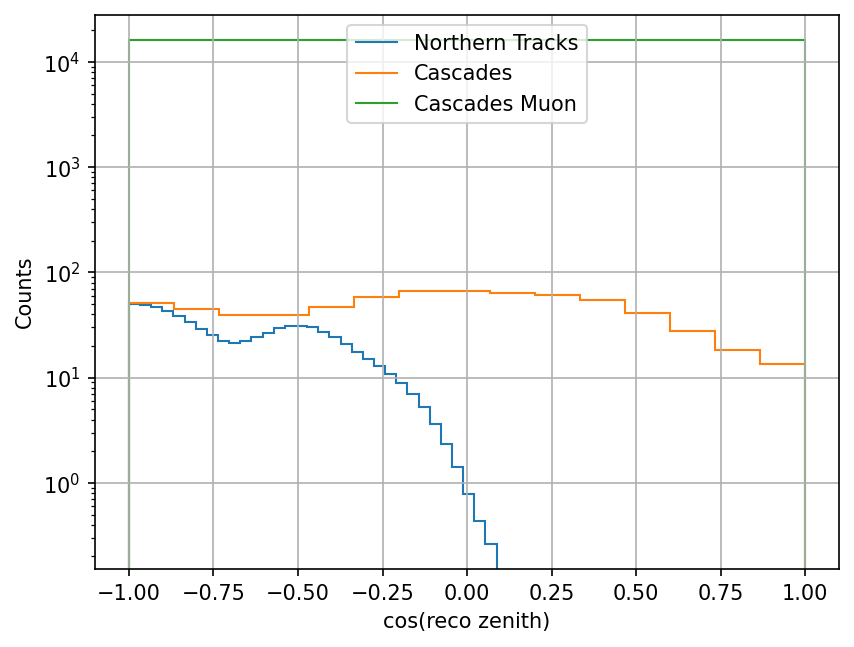

In [10]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
plt.figure(dpi=150)
for det in Datasets:
    binning = ana.expectations[det].binning
    hsum = hist[det].reshape(binning.hist_dims).sum(axis=0)
    plt.stairs(edges = binning.bin_edges[1], values=hsum, label = det)
    plt.yscale("log")
plt.xlabel("cos(reco zenith)")
plt.ylabel("Counts")
plt.legend()
plt.grid()

In [12]:
bound_config = {
    "conv_norm": {"flux_norm": (0., np.inf)},
    "powerlaw": {"flux_norm": (0., np.inf), "spectral_index": (1.0, 5.0)},
    "delta_gamma": {"delta_gamma": (-0.1, 0.1)},
    "barr_gradients": {"barr_h": (-1, 5), "barr_w": (-1, 5), "barr_y": (-1, 5), "barr_z": (-0.244, 5)},
    "prompt_norm": {"flux_norm": (0., np.inf)},
    "CR_intp": {"lambda_int": (-1., 2)},
    "SnowStormSystematics": {"dom_eff": (0.9, 1.1), "ice_abs": (0.9, 1.1), "ice_scat": (0.9, 1.1), "ice_holep0": (-0.84, 0.3), "ice_holep1": (-0.134, 0.05)},
    "MuonTemplate": {"flux_norm": (0., np.inf)},
    "MuonGunTemplate": {"flux_norm": (0., np.inf)},
    "effective_veto": {"e_threshold": (-1.301, 1.301)},
}

defaults = {
    "conv_norm": {"flux_norm": 1.},
    "powerlaw": {"flux_norm": 1.44, "spectral_index": 2.37},
    "delta_gamma": {"delta_gamma": 0.},
    "barr_gradients": {"barr_h": 0., "barr_w": 0., "barr_y": 0.0, "barr_z": 0.},
    "prompt_norm": {"flux_norm": 1.},
    "CR_intp": {"lambda_int": 0.},
    "SnowStormSystematics": {"dom_eff": 1.0, "ice_abs": 1.00, "ice_scat":1.000, "ice_holep0": -0.27, "ice_holep1":-0.042},
    "MuonTemplate": {"flux_norm": 1.0},
    "MuonGunTemplate": {"flux_norm": 1.0},
    "effective_veto": {"e_threshold": 0.0},
}
priors = {
    "barr_gradients": {"barr_h": (0, 0.15), "barr_w": (0, 0.4), "barr_y": (0, 0.3), "barr_z": (0, 0.12)},
    "CR_intp": {"lambda_int": (0, 1)},
    "MuonTemplate": {"flux_norm": (0, 0.5)},
}

In [8]:
import scipy.optimize
class Scipy_Minimizer:
    def __init__(self,
                 llh: pyFF.likelihood.AbstractLikelihood,
                 obs: dict,
                 dataset: dict,
                 exposed_vars,
                 bounds,
                 Seeds,
                 Priors = {},
                 fixed_pars = {}):
        prior_objects = []
        for factor, pars in Priors.items():
            prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
        wrapped_lh = pyFF.minimizer.WrappedLLH(llh, obs, dataset, fixed_pars, prior_objects)
        self.fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))
        self.par_idx_map = pyFF.minimizer.flat_index_dict_mapping(exposed_vars, fixed_pars)
        bounds_lower = []
        bounds_upper = []
        self.seeds = []
        print(self.par_idx_map)
        for factor, pars in self.par_idx_map.items():
            for par in pars:
                lower, upper = bounds[factor][par]
                bounds_lower.append(lower)
                bounds_upper.append(upper)
                self.seeds.append(Seeds[factor][par])
        self.bounds = scipy.optimize.Bounds(bounds_lower, bounds_upper)
    def minimize(self):
        result = scipy.optimize.minimize(
            self.fmin_and_grad,
            self.seeds,
            bounds=self.bounds,
            jac=True,
            method="L-BFGS-B",
            tol=1e-8,
            options={"maxls": 50, }
            )
        return result

In [9]:
minimizer = Scipy_Minimizer(
    lik, 
    obs,
    dataset,
    ana.exposed_variables(),
    bound_config,
    defaults,
    priors,
    fixed_pars = {}
    )
injected_pars = []
print(ana.exposed_variables())
print(lik.llh(obs, dataset, model_parameters))
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        injected_pars.append(model_parameters[factor][par])
print(injected_pars)
injec_llh = minimizer.fmin_and_grad(injected_pars)
print(injec_llh)

{'powerlaw': {'flux_norm': 0, 'spectral_index': 1}, 'conv_norm': {'flux_norm': 2}, 'delta_gamma': {'delta_gamma': 3}, 'barr_gradients': {'barr_h': 4, 'barr_w': 5, 'barr_z': 6, 'barr_y': 7}, 'CR_intp': {'lambda_int': 8}, 'prompt_norm': {'flux_norm': 9}}
{'powerlaw': ['flux_norm', 'spectral_index'], 'conv_norm': ['flux_norm'], 'delta_gamma': ['delta_gamma'], 'barr_gradients': dict_keys(['barr_h', 'barr_w', 'barr_z', 'barr_y']), 'CR_intp': ['lambda_int'], 'prompt_norm': ['flux_norm']}


0.0
[1.8, 2.52, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
(Array(0., dtype=float64), [Array(-1.03717862e-13, dtype=float64, weak_type=True), Array(-5.46551444e-13, dtype=float64, weak_type=True), Array(-9.73880369e-12, dtype=float64, weak_type=True), Array(-9.39110295e-12, dtype=float64, weak_type=True), Array(-2.61096381e-12, dtype=float64, weak_type=True), Array(-1.8487939e-12, dtype=float64, weak_type=True), Array(-5.82034121e-12, dtype=float64, weak_type=True), Array(-4.88339185e-12, dtype=float64, weak_type=True), Array(-5.91608864e-13, dtype=float64, weak_type=True), Array(-2.72818304e-14, dtype=float64, weak_type=True)])


In [10]:

result = minimizer.minimize()

In [11]:
print(result)
for factor, pars in minimizer.par_idx_map.items():
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {result.x[val]:0.3f}, grad: {result.jac[val]:0.3f}")

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0002783150169364209
        x: [ 1.760e+00  2.513e+00  9.999e-01  4.794e-05  2.827e-05
            -5.829e-05 -1.370e-05  5.693e-05  2.033e-04  1.280e+00]
      nit: 186
      jac: [ 1.819e-03  1.032e-02 -6.169e-03 -1.026e-02 -5.315e-03
             2.178e-03  3.030e-03  4.380e-03 -2.801e-03  2.563e-03]
     nfev: 211
     njev: 211
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
powerlaw
flux_norm: 1.760, grad: 0.002
spectral_index: 2.513, grad: 0.010
conv_norm
flux_norm: 1.000, grad: -0.006
delta_gamma
delta_gamma: 0.000, grad: -0.010
barr_gradients
barr_h: 0.000, grad: -0.005
barr_w: -0.000, grad: 0.002
barr_z: -0.000, grad: 0.003
barr_y: 0.000, grad: 0.004
CR_intp
lambda_int: 0.000, grad: -0.003
prompt_norm
flux_norm: 1.280, grad: 0.003


In [10]:
import iminuit
class Minuit_Minimizer:
    def __init__(self,
                 llh: pyFF.likelihood.AbstractLikelihood,
                 obs: dict,
                 dataset: dict,
                 exposed_vars,
                 bounds,
                 Seeds,
                 Priors = {},
                 fixed_pars = {}):
        prior_objects = []
        for factor, pars in Priors.items():
            prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
        wrapped_lh = pyFF.minimizer.WrappedLLH(llh,
                                               obs,
                                               dataset,
                                               fixed_pars,
                                               prior_objects)
        self.func = jax.jit(wrapped_lh)
        self.grad = jax.jit(jax.grad(wrapped_lh))
        print("Compiled Likelihood function and gradient")
        self.par_idx_map = pyFF.minimizer.flat_index_dict_mapping(exposed_vars, fixed_pars)
        self.seeds = []
        self.par_names = []
        bound_list = []
        #print(self.par_idx_map)
        for factor, pars in self.par_idx_map.items():
            for par in pars:
                self.seeds.append(Seeds[factor][par])
                self.par_names.append(f"{factor}_{par}")
                lower, upper = bounds[factor][par]
                bound_list.append([lower, upper])
        print("Setup Minimizer")
        self.minuit = iminuit.Minuit(
            self.func,
            self.seeds,
            grad=self.grad,
            name=self.par_names
        )
        self.minuit.errordef = self.minuit.LIKELIHOOD
        self.minuit.limits = np.array(bound_list)
        self.minuit.strategy = 1
        self.minuit.tol = 1e-2
        self.minuit.print_level = 0
    def _build_message(self):
        """
        Helper function for building a short fit message.
        """
        if self.minuit.valid:
            message = "Optimization terminated successfully"
            if self.minuit.accurate:
                message += "."
            else:
                message += ", but uncertainties are unrealiable."
        else:
            message = "Optimization failed."
            fmin = self.minuit.fmin
            if fmin.has_reached_call_limit:
                message += " Call limit was reached."
            if fmin.is_above_max_edm:
                message += " Estimated distance to minimum too large."

        return message
    def minimize(self):
        print("Starting Minimization")
        self.minuit.migrad()
        print("Finished Minimization")
        minimizer_info = {
            'success': self.minuit.valid,
            'message': self._build_message(),
            'nfev': self.minuit.nfcn,
            'njev': self.minuit.ngrad,
            'hess_inv': self.minuit.covariance,
        }
        res_dict = {
            var: self.minuit.values[var]
            for var in self.par_names
        }
        fun = self.minuit.fval
        print("best-fit llh: ", fun)
        print("----------------")
        print("best-fit parameters:")
        for factor, pars in self.par_idx_map.items():
            print("")
            print(factor)
            for par, val in pars.items():
                print(f"{par}: {res_dict[factor+'_'+par]:0.3f}")
        print("----------------")
        
        return minimizer_info, res_dict, fun

In [13]:
astro_scan = np.linspace(0, 2.5, 20)
scan_res = []
par_res = []
for astro in astro_scan:
    print("#####################")
    print("astro_norm:", astro)
    minuit_min = pyFF.minimizer.Minuit_Minimizer(lik,
                                obs,
                                dataset,
                                ana.exposed_variables(),
                                bound_config,
                                defaults,
                                Priors = priors,
                                fixed_pars = {"powerlaw": {"flux_norm": astro}})
    minuit_result = minuit_min.minimize()
    #print(minuit_result[2])
    scan_res.append(minuit_result[2])
    par_res.append(minuit_result[1])
    print("#####################")

#####################
astro_norm: 0.0
Compiled Likelihood function and gradient
Setup Minimizer
Starting Minimization
Finished Minimization
best-fit llh:  183.61697549345195
----------------
best-fit parameters:

powerlaw
spectral_index: 2.370

conv_norm
flux_norm: 1.264

delta_gamma
delta_gamma: -0.100

barr_gradients
barr_h: -0.028
barr_w: 0.506
barr_z: -0.105
barr_y: -0.227

CR_intp
lambda_int: -0.817

effective_veto
e_threshold: 1.146

prompt_norm
flux_norm: 10.997

SnowStormSystematics
dom_eff: 1.002
ice_abs: 1.007
ice_scat: 1.006
ice_holep0: -0.288
ice_holep1: -0.052

MuonTemplate
flux_norm: 0.328

MuonGunTemplate
flux_norm: 0.920
----------------
#####################
#####################
astro_norm: 0.13157894736842105
Compiled Likelihood function and gradient
Setup Minimizer
Starting Minimization
Finished Minimization
best-fit llh:  83.15434319752104
----------------
best-fit parameters:

powerlaw
spectral_index: 1.685

conv_norm
flux_norm: 1.306

delta_gamma
delta_gamma: -0.

In [14]:
ref_data = pd.read_hdf("/data/ana/Diffuse/GlobalFit/fits/Tracks_NoCscd/SPL/Gradient_baseline/asimov/poisson/ScanResults.hdf")
print(ref_data.loc["freefit"])

    CR_grad astro_norm    barr_h    barr_w    barr_y    barr_z conv_norm  \
0  0.000033   1.440008 -0.000002  0.000002 -0.000012  0.000009  1.000003   

  delta_gamma dom_eff effective_veto fit_success gamma_astro ice_abs  \
0         0.0     1.0       1.000003        True    2.370002     1.0   

  ice_holep0 ice_holep1 ice_scat  llh muon_norm muongun_norm prompt_norm  
0  -0.269998     -0.042      1.0  0.0  1.000022          1.0    0.999953  


0         0.75
1     0.839286
2     0.928571
3     1.017857
4     1.107143
5     1.196429
6     1.285714
7        1.375
8     1.464286
9     1.553571
10    1.642857
11    1.732143
12    1.821429
13    1.910714
14         2.0
Name: astro_norm, dtype: object


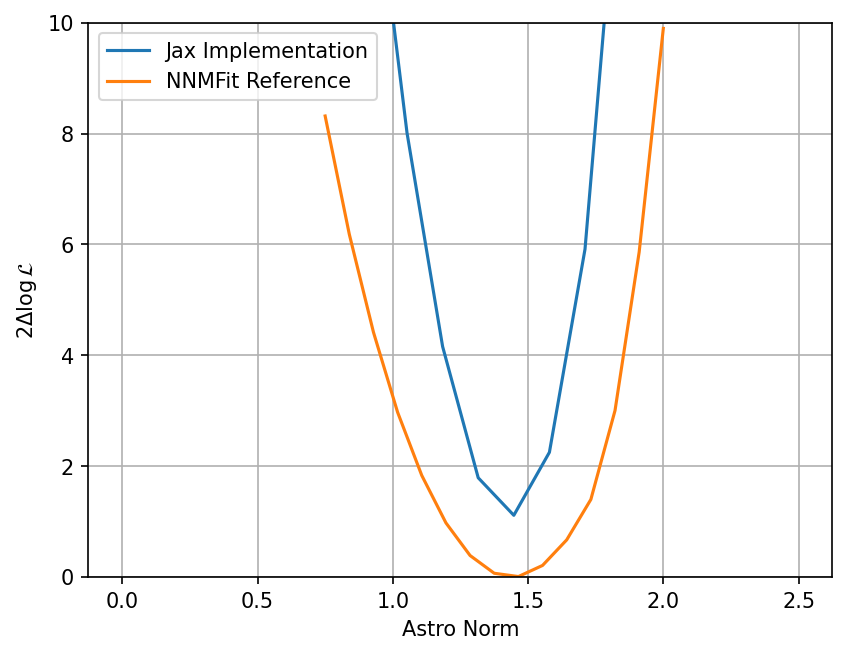

In [16]:
fig, ax = plt.subplots(dpi=150)
print(ref_data.astro_norm.loc["astro_norm"])
ax.plot(astro_scan, np.array(scan_res), label = "Jax Implementation")
sort_by = np.argsort(ref_data.astro_norm.loc["astro_norm"])
ax.plot(ref_data.astro_norm.loc["astro_norm"][sort_by], 2*ref_data.llh.loc["astro_norm"][sort_by], label = "NNMFit Reference")
ax.set_xlabel("Astro Norm")
ax.set_ylabel(r"2$\Delta  \log \mathcal{L}$")
ax.set_ylim(0, 10)  
ax.grid(True)
ax.legend()

In [13]:
prior_objects = []
for factor, pars in priors.items():
    prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
wrapped_lh = pyFF.minimizer.WrappedLLH(
    lik,
    obs,
    dataset,
    {},
    prior_objects
    )
hess_func = jax.jit(jax.hessian(wrapped_lh))

In [14]:
injected_pars = []
minimizer = Minuit_Minimizer(
    lik,
    obs,
    dataset,
    ana.exposed_variables(),
    bound_config,
    defaults,
    Priors = priors,
    fixed_pars = {}
    )
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        injected_pars.append(model_parameters[factor][par])
hesse = hess_func(injected_pars)

Compiled Likelihood function and gradient
Setup Minimizer


In [18]:
import jax.profiler
llh_function = jax.jit(wrapped_lh)
# Start profiling and collect trace data
#with jax.profiler.trace():
jax.profiler.start_trace("/tmp/profile",)
llh_function(injected_pars)
jax.profiler.stop_trace()

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:449] tensorflow.profiler.XSpace exceeded maximum protobuf size of 2GB: 2314320987


In [33]:
cov = np.linalg.inv(hesse)
for factor, pars in minimizer.par_idx_map.items():
    print("------")
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {injected_pars[val]:0.2f} +- {np.sqrt(cov[val, val]):0.3f}")

------
powerlaw
flux_norm: 1.80 +- 1.743
spectral_index: 2.52 +- 0.298
------
conv_norm
flux_norm: 1.00 +- 0.087
------
delta_gamma
delta_gamma: 0.00 +- 0.021
------
barr_gradients
barr_h: 0.00 +- 0.098
barr_w: 0.00 +- 0.252
barr_z: 0.00 +- 0.075
barr_y: 0.00 +- 0.134
------
CR_intp
lambda_int: 0.00 +- 0.227
------
prompt_norm
flux_norm: 1.00 +- 12.167
------
SnowStormSystematics
dom_eff: 1.00 +- 0.000
ice_abs: 1.00 +- 0.000
ice_scat: 1.00 +- 0.000
ice_holep0: -0.27 +- 0.000
ice_holep1: -0.04 +- 0.000


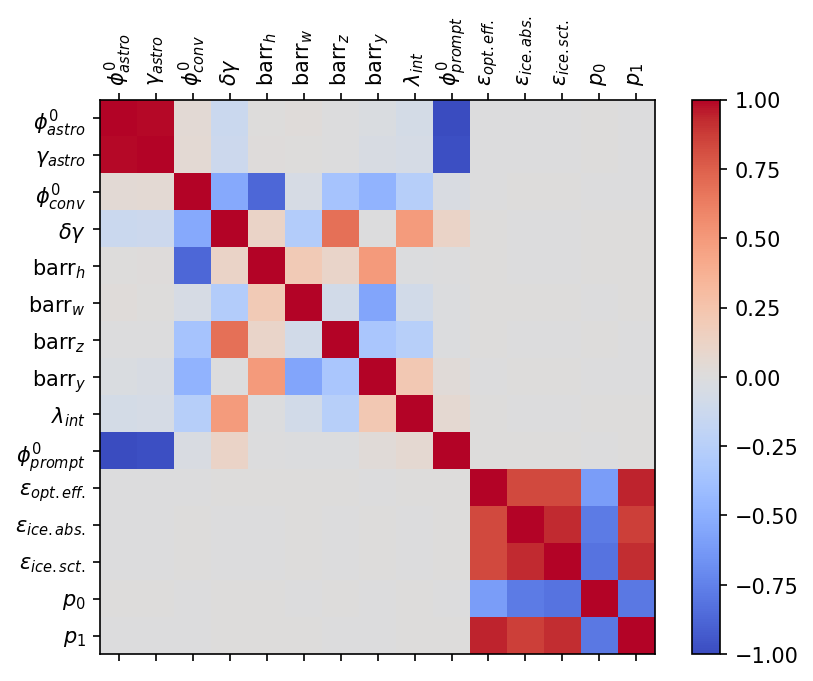

In [41]:
par_name_dict = {
    "powerlaw": {"flux_norm": r"$\phi_{astro}^0$", "spectral_index": r"$\gamma_{astro}$"},
    "conv_norm": {"flux_norm": r"$\phi_{conv}^0$"},
    "prompt_norm": {"flux_norm": r"$\phi_{prompt}^0$"},
    "delta_gamma": {"delta_gamma": r"$\delta \gamma$"},
    "barr_gradients": {"barr_h": r"barr-h", "barr_w": r"barr-w", "barr_y": r"barr-y", "barr_z": r"barr-z"},
    "CR_intp": {"lambda_int": r"$\lambda_{CR}$"},
    "SnowStormSystematics": {"dom_eff": r"$\epsilon_{opt. eff.}$", "ice_abs": r"$\epsilon_{ice. abs.}$", "ice_scat": r"$\epsilon_{ice. sct.}$", "ice_holep0": r"$p_0$", "ice_holep1": r"$p_1$"},   
}

par_names = []
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        par_names.append(par_name_dict[factor][par])

fig, ax = plt.subplots(dpi=150)
p = ax.matshow(cov/np.sqrt(np.diag(cov)[:, None]*np.diag(cov)[None, :]), vmin = -1, vmax = 1, cmap="coolwarm")
fig.colorbar(p)
ax.set_xticks(range(len(minimizer.par_names)), par_names, rotation=90)
ax.set_yticks(range(len(minimizer.par_names)), par_names)

In [20]:
jax.profiler.start_trace("/tmp/profile",)
minuit_result = minimizer.minimize()
jax.profiler.stop_trace()
for factor, pars in minuit_min.par_idx_map.items():
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {minuit_result[1][factor + "_" + par]:0.3f}")
print("llh: " , minuit_result[2])

Starting Minimization


Finished Minimization
best-fit llh:  0.005182422397759163
----------------
best-fit parameters:

powerlaw
flux_norm: 1.388
spectral_index: 2.358

conv_norm
flux_norm: 1.001

delta_gamma
delta_gamma: -0.000

barr_gradients
barr_h: -0.000
barr_w: -0.001
barr_z: -0.001
barr_y: -0.001

CR_intp
lambda_int: 0.001

prompt_norm
flux_norm: 0.370

SnowStormSystematics
dom_eff: 1.000
ice_abs: 1.000
ice_scat: 1.000
ice_holep0: -0.269
ice_holep1: -0.042
----------------
powerlaw
spectral_index: 2.358
conv_norm
flux_norm: 1.001
delta_gamma
delta_gamma: -0.000
barr_gradients
barr_h: -0.000
barr_w: -0.001
barr_z: -0.001
barr_y: -0.001
CR_intp
lambda_int: 0.001
prompt_norm
flux_norm: 0.370
SnowStormSystematics
dom_eff: 1.000
ice_abs: 1.000
ice_scat: 1.000
ice_holep0: -0.269
ice_holep1: -0.042
llh:  0.005182422397759163


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:449] tensorflow.profiler.XSpace exceeded maximum protobuf size of 2GB: 4681815112
